In [1]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import sys
sys.path.append('../')
import dataloaders
from torch.utils.data import DataLoader


Dataset = dataloaders.iCIFAR100
num_classes = 100
dataset_size = [32,32,3]
dataroot=os.path.join('/data', 'cifar100')
dataset='CIFAR100'
seed=0
first_split_size=20
other_split_size=20
i=1
# load tasks
class_order = np.arange(num_classes).tolist()
class_order_logits = np.arange(num_classes).tolist()
rand_split = True
if rand_split:
    print('=============================================')
    print('Shuffling....')
    print('pre-shuffle:' + str(class_order))
    if dataset == 'ImageNet':
        np.random.seed(1993)
        np.random.shuffle(class_order)
    else:
        random.seed(seed)
        random.shuffle(class_order)
    print('post-shuffle:' + str(class_order))
    print('=============================================')
tasks = []
tasks_logits = []
p = 0
max_task = 5
dataset='CIFAR100'

while p < num_classes and (max_task == -1 or len(tasks) < max_task):
    inc = other_split_size if p > 0 else first_split_size
    tasks.append(class_order[p:p+inc])
    tasks_logits.append(class_order_logits[p:p+inc])
    p += inc
num_tasks = len(tasks)
task_names = [str(i+1) for i in range(num_tasks)]

# number of tasks to perform
if max_task > 0:
    max_task = min(max_task, len(task_names))
else:
    max_task = len(task_names)

# datasets and dataloaders
test_transform  = dataloaders.utils.get_transform(dataset=dataset, phase='test', aug=False, dgr=False)
test_dataset  = Dataset(dataroot, train=False, tasks=tasks,
                        download_flag=False, transform=test_transform, 
                        seed=0, validation=False)

# save this for E2E baseline
# train_dataset.simple_transform = dataloaders.utils.get_transform(dataset=dataset, phase='test', aug=False, dgr=False)

# learn
# train_dataset.load_dataset(i, train=False)
test_dataset.load_dataset(i, train=False)
# load dataloader
# train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True, num_workers=int(2))
test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, drop_last=False, num_workers=2)

Shuffling....
pre-shuffle:[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
post-shuffle:[23, 8, 11, 7, 48, 13, 1, 91, 94, 54, 16, 63, 52, 41, 80, 2, 47, 87, 78, 66, 19, 6, 24, 10, 59, 30, 22, 29, 83, 37, 93, 81, 43, 99, 86, 28, 34, 88, 44, 14, 84, 70, 4, 20, 15, 21, 31, 76, 57, 67, 73, 50, 69, 25, 98, 46, 96, 0, 72, 35, 58, 92, 3, 95, 56, 90, 26, 40, 55, 89, 75, 71, 60, 42, 9, 82, 39, 18, 77, 68, 32, 79, 12, 85, 36, 17, 64, 27, 74, 45, 61, 38, 51, 62, 65, 33, 5, 53, 97, 49]
[ 1  2  6  7  8 10 11 13 14 16 19 22 23 24 28 29 30 34 37 41 43 44 47 48
 52 54 59 63 66 78 80 81 83 86 87 88 91 93 94 99]


In [2]:

from models.resnet import ResNet,resnet32

model = resnet32(out_dim=num_classes)
model_path='class'
# model_path='class_2task_iscf'
model.load_state_dict(torch.load('./'+model_path+'.pth'))
model.cuda()
model.eval()
print("DONE")

DONE


In [3]:
xs=[]
ys=[]
count=0
for data in test_loader:
    x, y, t = data
    x = x.cuda()
    y = y.cuda()
    with torch.no_grad():
        logits = model(x,pen=True)
        # if (y==10).sum()>0:
        #     break
        xs.append(logits.cpu().detach().numpy())
        ys.append(y.cpu().detach().numpy())
        count+=(model.last(logits)[:,:first_split_size*(i+1)].argmax(dim=1)==y).sum().cpu()
    
xs=np.concatenate(xs,axis=0)
ys=np.concatenate(ys,axis=0)
print(count)
print(xs.shape,ys.shape)
print(np.unique(ys))
print(count/xs.shape[0])

tensor(2773)
(4000, 64) (4000,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
tensor(0.6933)


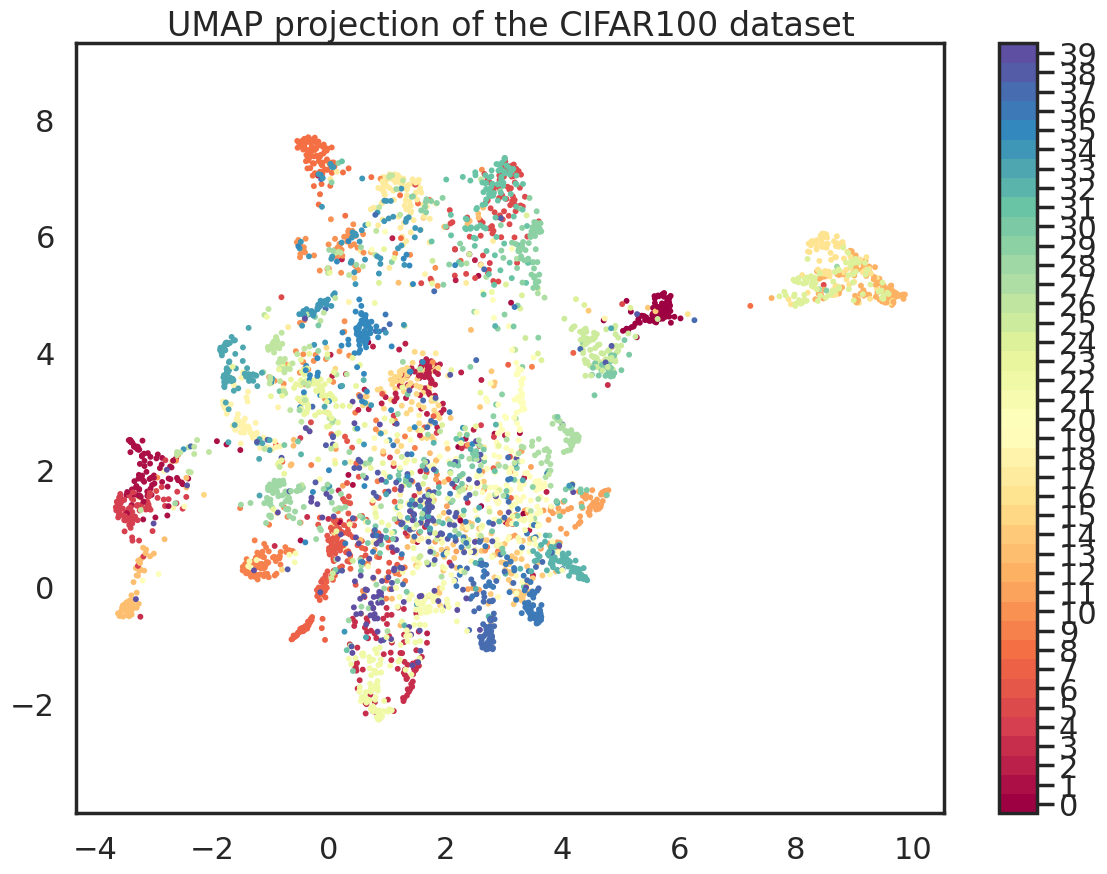

In [4]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP()
embedding = reducer.fit_transform(xs)
plt.scatter(embedding[:, 0], embedding[:, 1], c=ys, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(first_split_size*(i+1)+1)-0.5).set_ticks(np.arange(first_split_size*(i+1)))
plt.title('UMAP projection of the CIFAR100 dataset', fontsize=24)
plt.savefig(f'./{model_path}_umap.png')
plt.show()

In [5]:
import torchvision

train_dataset=torchvision.datasets.CIFAR100(dataroot,train=True,transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=False, num_workers=int(2))

In [6]:
xs=[]
ys=[]
count=0
mapping=[ 1,  2,  6,  7,  8, 10, 11, 13, 14, 16, 19, 22, 23, 24, 28, 29, 30, 34, 37, 41, 43, 44, 47, 48,
 52, 54, 59, 63, 66, 78, 80, 81, 83, 86, 87, 88, 91, 93, 94, 99]
for x,y in train_loader:
    x=x.cuda()
    y=y.cuda()
    with torch.no_grad():
        logits = model(x,pen=True)
    # if (y==10).sum()>0:
    #     break
    indices= (y < (first_split_size*(i+1)))
    logits = logits[indices]
    x = x[indices]
    y = y[indices]
    xs.append(logits.cpu().detach().numpy())
    ys.append(y.cpu().detach().numpy())
    count+=(model.last(logits)[:,:first_split_size*(i+1)].argmax(dim=1)==y).sum().cpu()
    
xs=np.concatenate(xs,axis=0)
ys=np.concatenate(ys,axis=0)
print(count)
print(xs.shape,ys.shape)
print(np.unique(ys))
print(count/xs.shape[0])

tensor(258)
(20000, 64) (20000,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
tensor(0.0129)


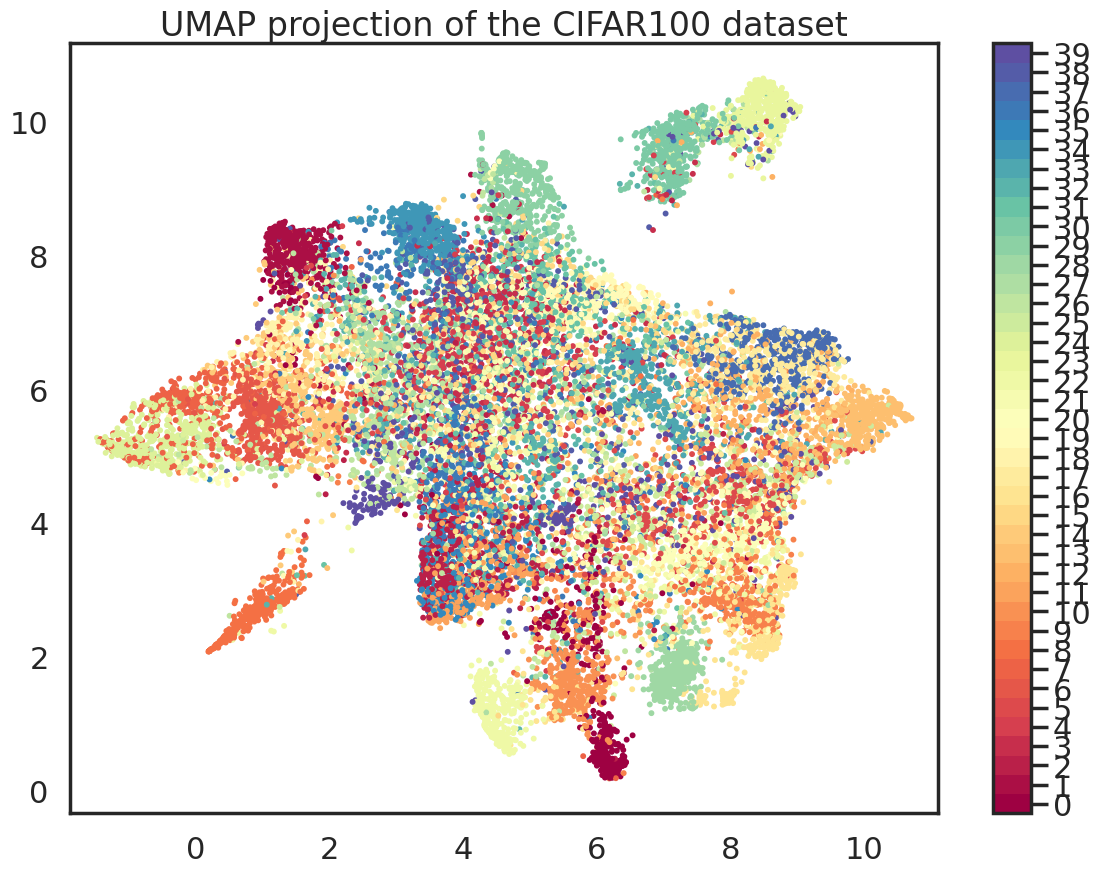

In [7]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})
reducer = umap.UMAP()
embedding = reducer.fit_transform(xs)
plt.scatter(embedding[:, 0], embedding[:, 1], c=ys, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(first_split_size*(i+1)+1)-0.5).set_ticks(np.arange(first_split_size*(i+1)))
plt.title('UMAP projection of the CIFAR100 dataset', fontsize=24)
plt.savefig(f'./{model_path}_umap.png')
plt.show()